In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load Data
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [3]:
#Encode categorical features
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['smoking_history'] = le.fit_transform(df['smoking_history'])

# Outlier Removal
for col in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

#Split into features and target
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# 5. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

#Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Accuracy: 0.9744993915256113

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     17177
           1       1.00      0.49      0.66       901

    accuracy                           0.97     18078
   macro avg       0.99      0.74      0.82     18078
weighted avg       0.98      0.97      0.97     18078



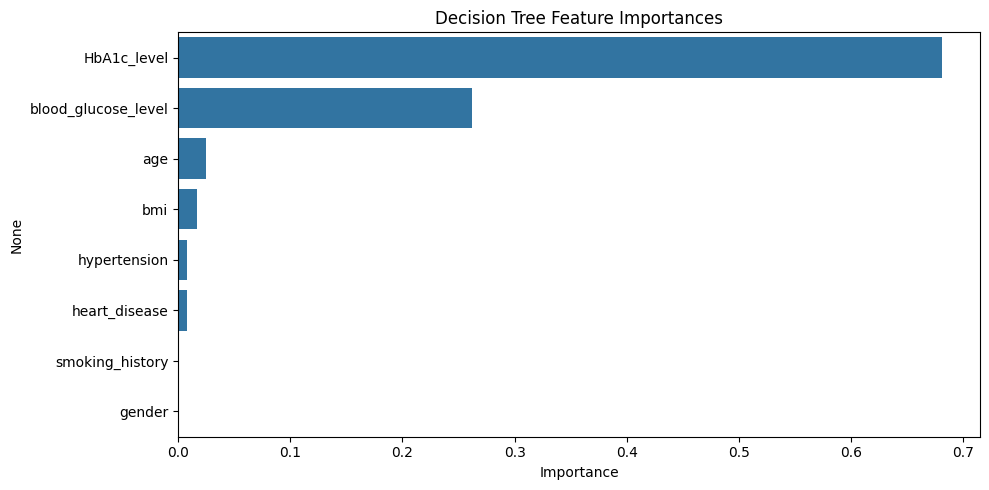

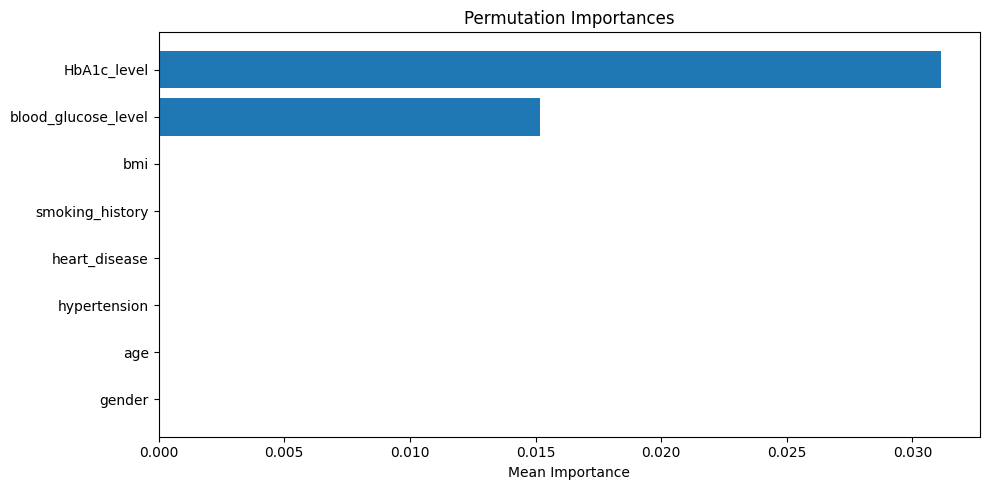

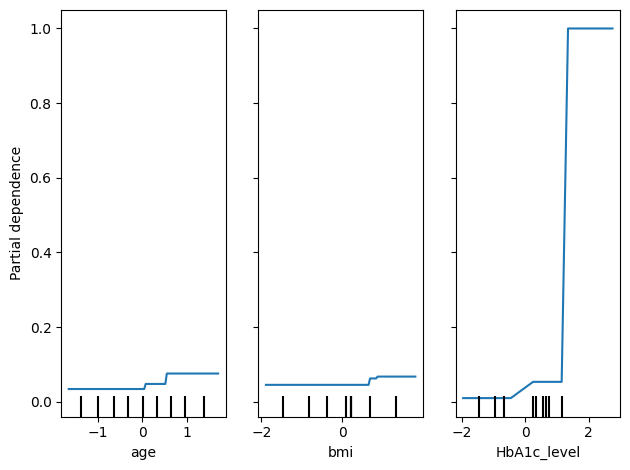

<Figure size 640x480 with 0 Axes>

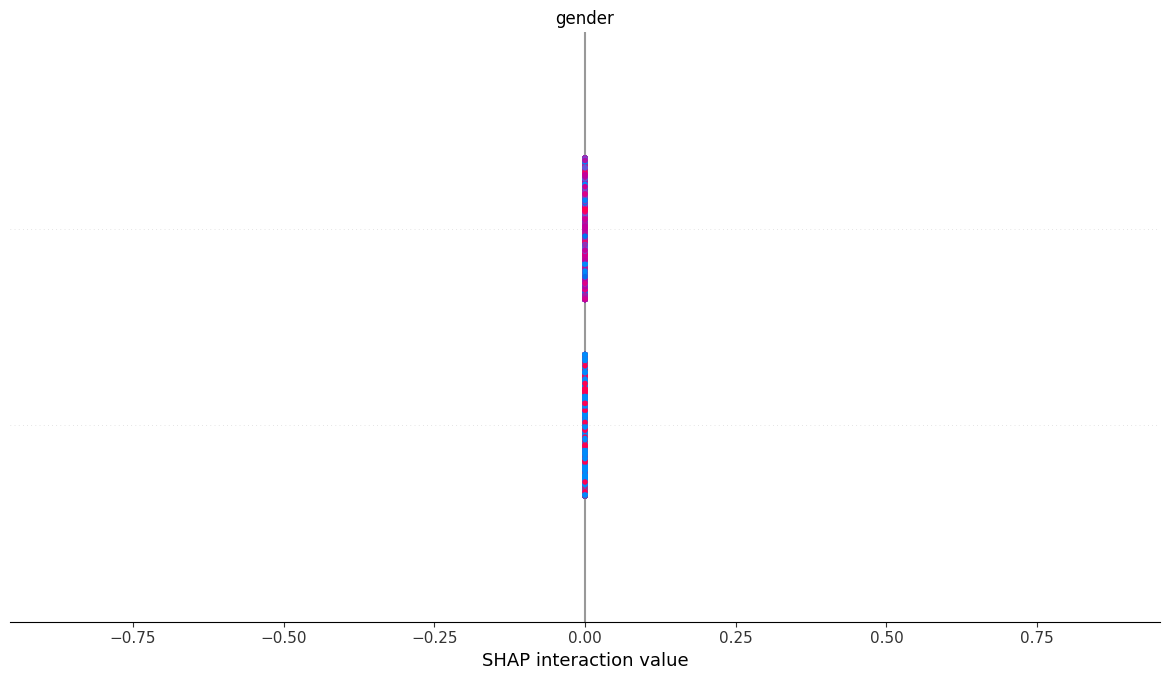

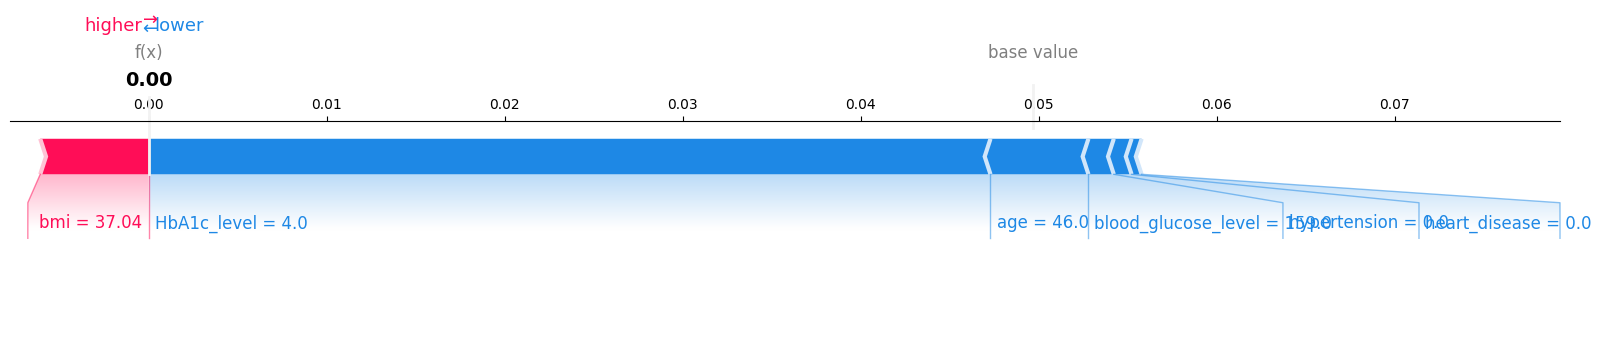

In [10]:
tree = DecisionTreeClassifier(max_depth=7, random_state=42)
tree.fit(X_train_scaled, y_train)


y_pred = tree.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

feature_names = X.columns
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Decision Tree Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


perm_result = permutation_importance(
    tree, X_test_scaled, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
sorted_idx = perm_result.importances_mean.argsort()
plt.figure(figsize=(10, 5))
plt.barh(feature_names[sorted_idx], perm_result.importances_mean[sorted_idx])
plt.title("Permutation Importances")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()


features_to_plot = ['age', 'bmi', 'HbA1c_level']
feature_indices = [feature_names.get_loc(feat) for feat in features_to_plot]

PartialDependenceDisplay.from_estimator(
    tree,
    X_test_scaled,
    features=feature_indices,
    feature_names=feature_names,
    kind="average"
)
plt.tight_layout()
plt.show()


explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X_test_scaled)


shap.summary_plot(
    shap_values,
    X_test,
    feature_names=feature_names,
    plot_type="bar"
)


i = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values[i, :, 1],
    X_test.iloc[i],
    matplotlib=True
)
